In [15]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *
from PIL import Image
import glob
import random
from tensorflow.keras import layers
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
tf.logging.set_verbosity(tf.logging.ERROR)

In [16]:
#directions = ['five', 'one']
def load_images(globpath):
    for image in globpath:
        with open(image, 'rb') as file:
            img = Image.open(file)
            img = img.resize((224, 224))
            np_img = np.array(img)
            my_list.append(np_img)

my_list = []
load_images(glob.glob("dataset3/*.JPG"))
my_list = np.array(my_list)
print('my_list.shape: ', my_list.shape)

my_list.shape:  (148, 224, 224, 3)


In [17]:
# 0 five (74), 1 one (74)
labels = [0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,
        0,0,0,0, 
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,
        1,1,1,1]
print("num labels: ",len(labels))
labels = np.array(labels)

num labels:  148


In [18]:
p = np.random.permutation(len(my_list))
X_orig = my_list[p]
Y_orig = labels[p]
print('shuffled labels:', Y_orig)

shuffled labels: [0 1 0 0 0 1 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1
 0 1 0 0 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0
 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1]


In [19]:
X_test_orig = X_orig[0:15]
Y_test_orig = Y_orig[0:15]
X_dev_orig = X_orig[16:31]
Y_dev_orig = Y_orig[16:31]
X_train_orig = X_orig[32:len(labels)]
Y_train_orig = Y_orig[32:len(labels)]

In [20]:
X_train = X_train_orig/255
X_test = X_test_orig/255
X_dev = X_dev_orig/225
Y_train = convert_to_one_hot(Y_train_orig, 10).T
Y_test = convert_to_one_hot(Y_test_orig, 10).T
Y_dev= convert_to_one_hot(Y_dev_orig, 10).T

In [21]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

def initialize_parameters():
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer = tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,"W2": W2}
    return parameters

def forward_prop(X, parameters, keep_prob = 0.5):
    W1 = parameters['W1']
    W2 = parameters['W2']
    rate=1-keep_prob
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    P2 = tf.layers.Flatten()(P2)
    Z3 = tf.keras.layers.Dense(10, activation=None)(P2)
    return Z3

def compute_cost(Z3, Y, beta=0.001):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3,labels=Y))
    regularizer = tf.nn.l2_loss(Z3)
    cost = tf.reduce_mean(cost + beta * regularizer)
    #cost = -tf.reduce_sum(Y*tf.log(tf.clip_by_value(Z3,1e-10,1.0)))
    #cost = -tf.reduce_sum(Y*tf.log(tf.clip_by_value(Z3,1e-10,1.0)))
    #labels_sum = tf.reduce_sum(Y, axis=-1)
    #print(labels)
    #softmax = tf.nn.softmax(Z3)
    #cost = tf.reduce_mean(-tf.reduce_sum(softmax * tf.log(Y), axis=-1))
    return cost

In [22]:
def model(X_train, Y_train, learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True):
    ops.reset_default_graph()                         
    tf.set_random_seed(1)
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = [] 
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_prop(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init)

        print("=========Training==========")
        
        for epoch in range(num_epochs):
            minibatch_cost = 0
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={X:X_train, Y:Y_train})
                minibatch_cost += temp_cost / num_minibatches

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
  
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predicted = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predicted, tf.argmax(Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        #print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})

        #train_accuracy = accuracy(predict_op.eval(), correct_prediction)
        #return train_accuracy, parameters


        saver = tf.train.Saver()
        saver.save(sess, 'hand_motions.ckpt')
        sess.close()
        
    return train_accuracy, parameters


In [23]:
def test(X_test, Y_test, parameters):                                     
    (m, n_H0, n_W0, n_C0) = X_test.shape             
    n_y = Y_test.shape[1]                            
    costs = [] 
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    Z3 = forward_prop(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()

    print("=====Validation or Testing=====")
    with tf.Session() as sess:
        sess.run(init)
        a = sess.run(cost, feed_dict={X: X_test, Y:Y_test})

        plt.plot(np.squeeze(a))
        #plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        #test_accuracy = accuracy(predict_op, correct_prediction)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        #print(accuracy)
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})   
        saver = tf.train.Saver()
        saver.save(sess, 'hand_motions.ckpt')
        sess.close()

        return test_accuracy

=========Training==========
Cost after epoch 0: 4.370270
Cost after epoch 5: 3.037169
Cost after epoch 10: 2.957486
Cost after epoch 15: 2.832905
Cost after epoch 20: 2.680752
Cost after epoch 25: 2.522856
Cost after epoch 30: 2.359883
Cost after epoch 35: 2.203151
Cost after epoch 40: 2.081613
Cost after epoch 45: 1.983238
Cost after epoch 50: 1.909107
Cost after epoch 55: 1.849130
Cost after epoch 60: 1.806874
Cost after epoch 65: 1.774022
Cost after epoch 70: 1.756822
Cost after epoch 75: 1.740554
Cost after epoch 80: 1.727880
Cost after epoch 85: 1.718188
Cost after epoch 90: 1.733827
Cost after epoch 95: 1.720645


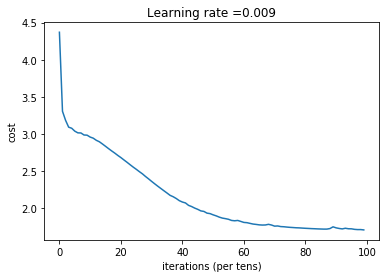

training accuracy:  1.0
=====Validation or Testing=====
validation accuracy:  0.0
=====Validation or Testing=====
test accuracy:  0.0
done


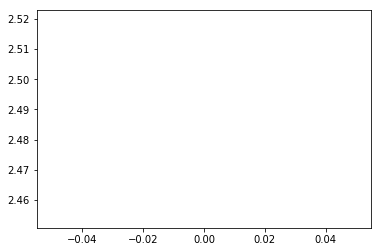

In [24]:
train, parameters = model(X_train, Y_train)
print("training accuracy: ", train)
dev = test(X_dev, Y_dev, parameters)
print("validation accuracy: ", str(dev))
test_accuracy = test(X_test, Y_test, parameters)
print("test accuracy: ", str(test_accuracy))
print('done')